## Model Exploration
This notebook contains our exploration of the XGBoost model in different configurations and sampling methods to accomodate for our data.

It initiates exploration using the final dataset we created in the Data_Preprocessing notebook, and as we continue to dive more into the models we pivot into encoding some features to reduce complexity and improve on causality.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataframes/final_df.csv")
df.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345979,51.570865,-0.231959,0,0,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
1,345980,51.603859,-0.187240,0,0,1,0,0,0,0,...,2,0,1,0,0,0,1,0,0,0
2,345981,51.512198,-0.153122,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,345982,51.431480,-0.016083,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
4,345983,51.473487,0.145202,0,0,0,1,0,0,0,...,2,0,0,0,0,1,1,0,0,0


Dropping Vehicle and Casualty related columns.

Our analysis is going to focus on the features that can help us predict the cause of the accidents (location, hour, day_of_the_week,...). 
For this reason we discard columns related to the aftermath of the accidents.

In [3]:

df = df.drop(['Car', 'Heavy_Vehicles',
       'Motorcycle', 'Other', 'Pedalcycle', 'casualty_age_0-23',
       'casualty_age_24-30', 'casualty_age_31-38', 'casualty_age_39-50',
       'casualty_age_50+'], axis=1)
print(df.columns)

Index(['id', 'lat', 'lon', 'severity', 'borough_Barking and Dagenham',
       'borough_Barnet', 'borough_Bexley', 'borough_Brent', 'borough_Bromley',
       'borough_Camden', 'borough_City of London',
       'borough_City of Westminster', 'borough_Croydon', 'borough_Ealing',
       'borough_Enfield', 'borough_Greenwich', 'borough_Hackney',
       'borough_Hammersmith and Fulham', 'borough_Haringey', 'borough_Harrow',
       'borough_Havering', 'borough_Hillingdon', 'borough_Hounslow',
       'borough_Islington', 'borough_Kensington and Chelsea',
       'borough_Kingston', 'borough_Lambeth', 'borough_Lewisham',
       'borough_Merton', 'borough_Newham', 'borough_Redbridge',
       'borough_Richmond upon Thames', 'borough_Southwark', 'borough_Sutton',
       'borough_Tower Hamlets', 'borough_Waltham Forest', 'borough_Wandsworth',
       'time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon',
       'time_of_day_Evening', 'month', 'day_of_week'],
      dtype='object')


In [4]:
X = df.drop(columns=['severity', 'id'])
y = df['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 41)
(10126, 41)
(40500,)
(10126,)


## XGBClassifier

To understand the XGBClassifier with our data we initiate a basic level exploration
Reviewing results with a confusion matrix and feature and permutation importance analysis.

In [5]:
random_state=42
base_xgb_model_no_sample_weight = XGBClassifier(random_state=random_state)
base_xgb_model_no_sample_weight.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.854     0.998     0.921      8606
           1      0.791     0.036     0.069      1469
           2      0.333     0.020     0.037        51

    accuracy                          0.854     10126
   macro avg      0.660     0.351     0.342     10126
weighted avg      0.842     0.854     0.793     10126



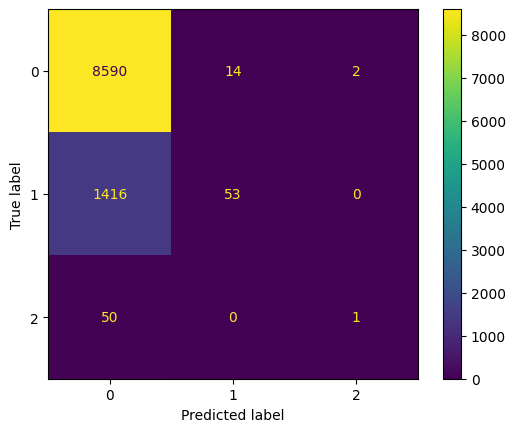

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = base_xgb_model_no_sample_weight.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

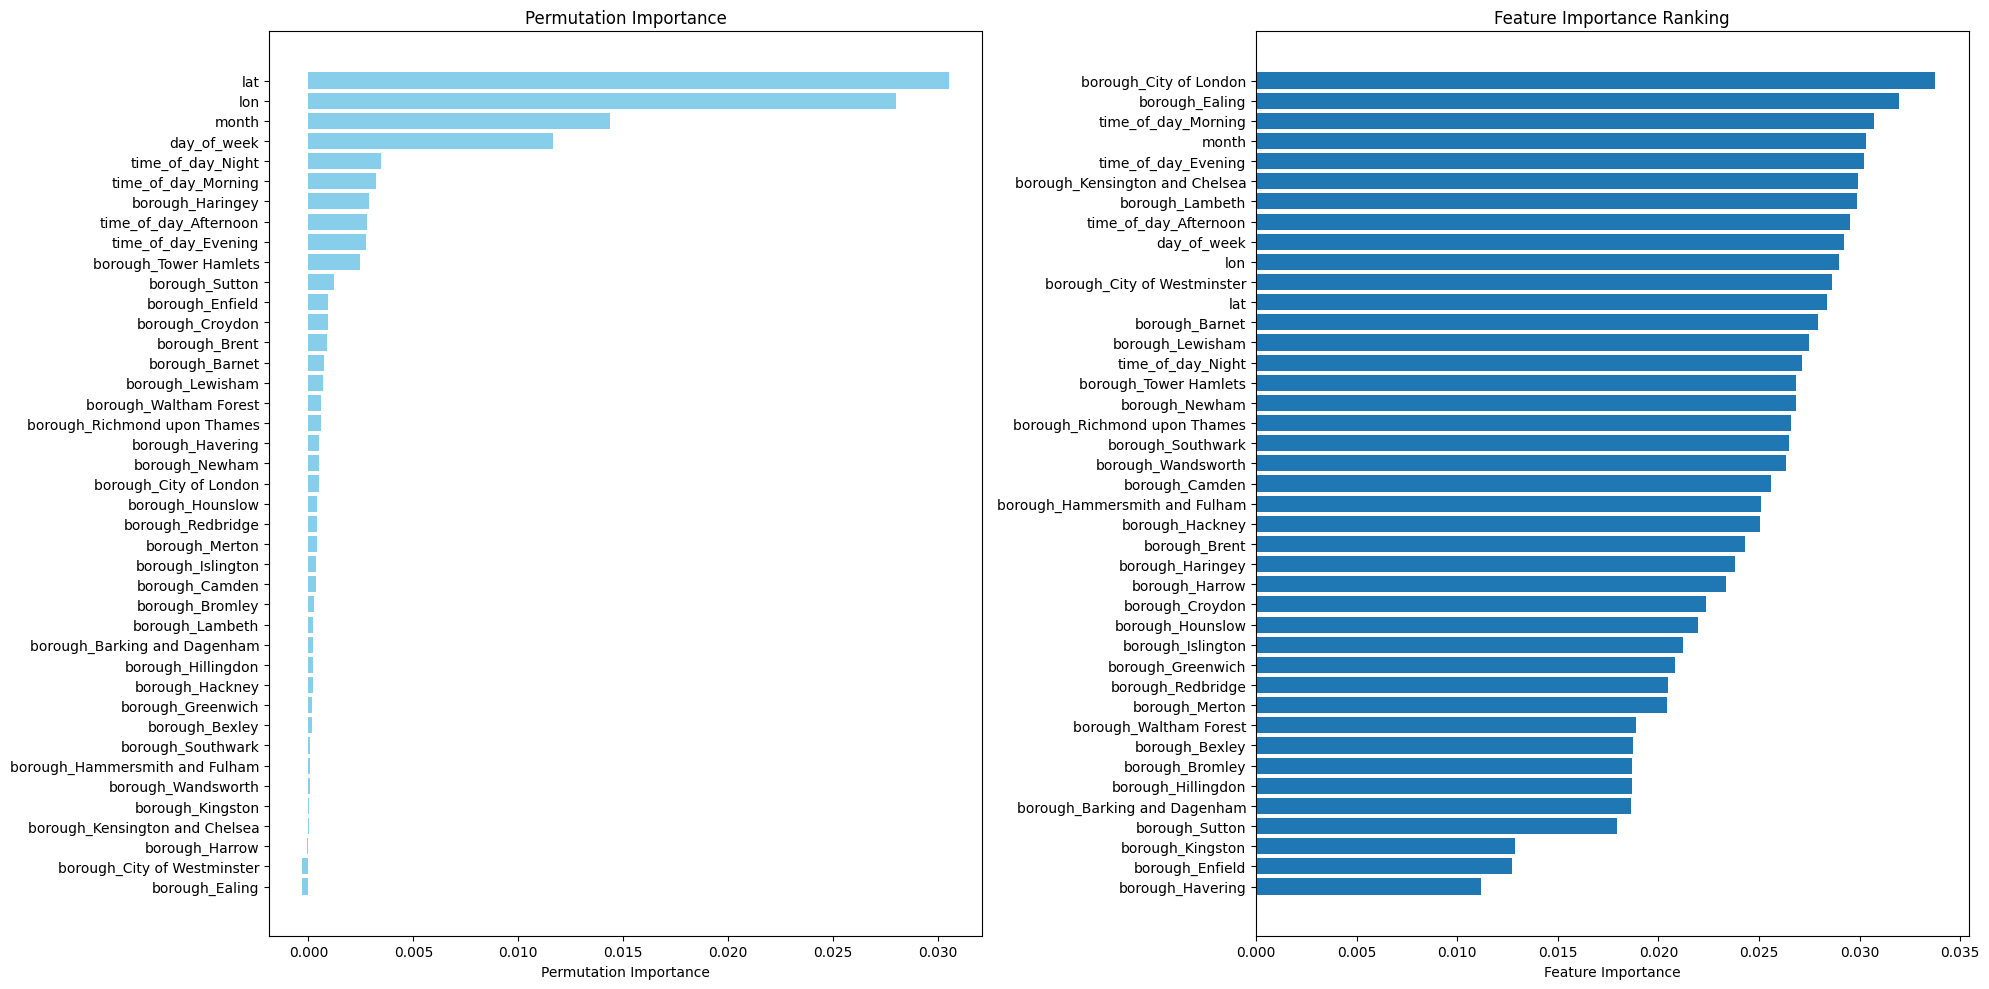

In [7]:
from sklearn.inspection import permutation_importance
feature_importance = base_xgb_model_no_sample_weight.feature_importances_

r_train = permutation_importance(base_xgb_model_no_sample_weight, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import roc_auc_score

 
y_proba      = base_xgb_model_no_sample_weight.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')


print(f'AUC score {xbm_score_test:.2f} (test)')

AUC score 0.79 (test)


Initial results demonstrate a clear bias towatds Slight or Class 0 Severity accidents since they take up the bulk of the reports.

However we start to see a clear importance of lat and lon features for the model prediction, followed by time based features and finally boroughs.

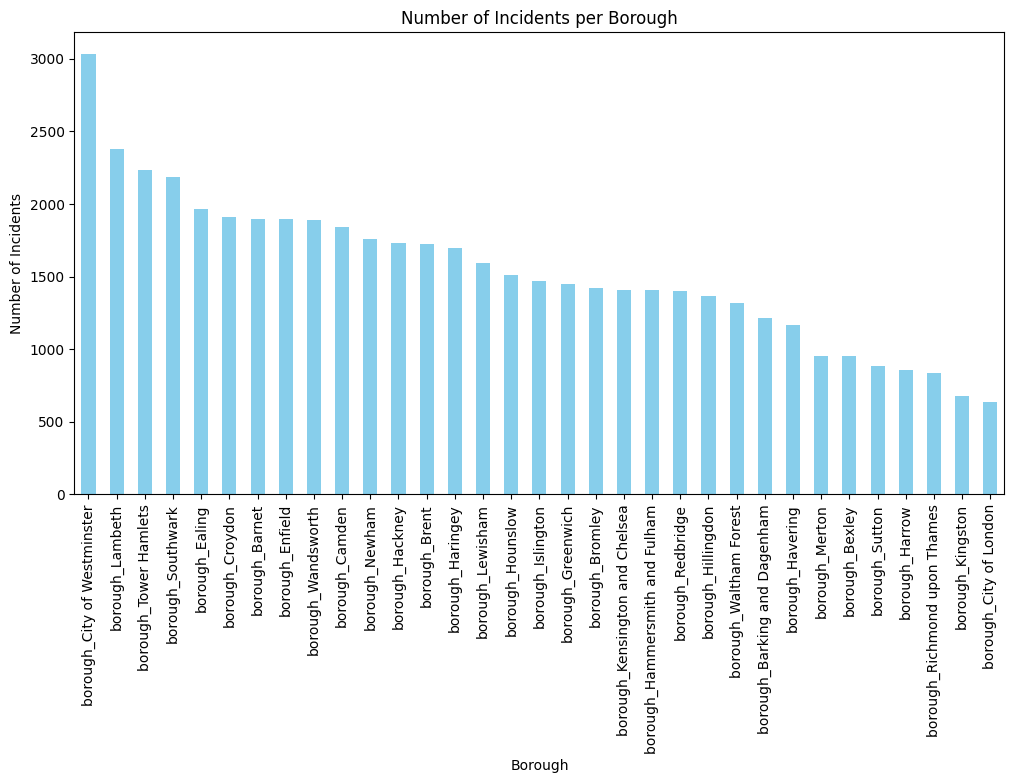

In [9]:
import matplotlib.pyplot as plt

def plot_incidents_by_borough(df):
    borough_cols = [col for col in df.columns if col.startswith("borough_")]
    borough_counts = df[borough_cols].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    borough_counts.plot(kind="bar", color="skyblue")
    plt.xticks(rotation=90)
    plt.xlabel("Borough")
    plt.ylabel("Number of Incidents")
    plt.title("Number of Incidents per Borough")
    plt.show()

# Esempio di utilizzo
plot_incidents_by_borough(df)

We dived a bit more into accidents per borough to see if the permutation importance of a borough is directly related to its amount of accidents that occured in that borough.

And we decided to do the same with Time based features to understand better our results.

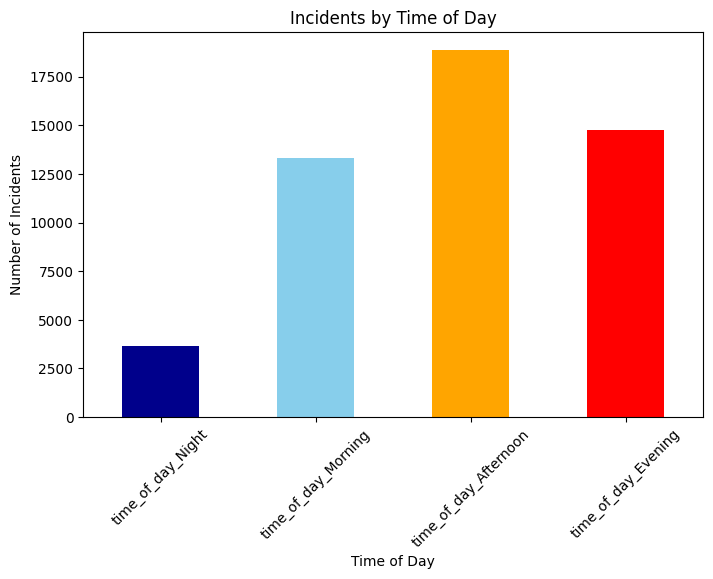

In [10]:
import matplotlib.pyplot as plt

def plot_incidents_by_time_of_day(df):
    time_of_day_cols = ['time_of_day_Night', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']
    
    # Conta gli incidenti per ogni fascia oraria
    incidents_count = df[time_of_day_cols].sum()
    
    # Plot
    plt.figure(figsize=(8,5))
    incidents_count.plot(kind='bar', color=['darkblue', 'skyblue', 'orange', 'red'])
    plt.xlabel("Time of Day")
    plt.ylabel("Number of Incidents")
    plt.title("Incidents by Time of Day")
    plt.xticks(rotation=45)
    plt.show()

plot_incidents_by_time_of_day(df)


Given that Boroughs start being important at lets say a third level degree we believe that they become more clutter than important features so we keep that in mind as we progress through our exploration.

## XGBClassifier using Sample Weights

To combat the class imbalance we started using Sample Weights.

In this case we used the "balance" flag to give higher weights to minority classes (1,2) and lower weights to majority classes (0) to help balance the model training.

In [8]:
random_state=42

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

base_xgb_model = XGBClassifier(random_state=random_state)
base_xgb_model.fit(X_train, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.915     0.734     0.814      8606
           1      0.282     0.596     0.383      1469
           2      0.319     0.725     0.443        51

    accuracy                          0.714     10126
   macro avg      0.505     0.685     0.547     10126
weighted avg      0.820     0.714     0.750     10126



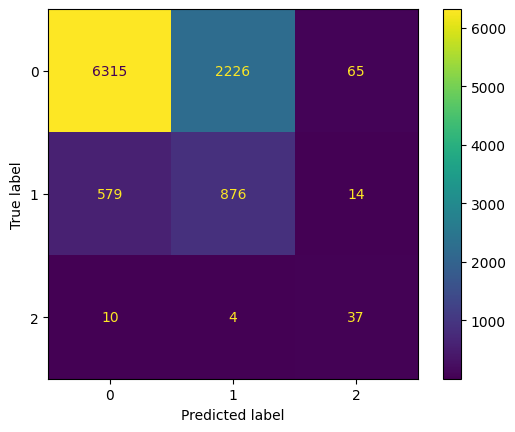

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = base_xgb_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

Printing Feature Importance from XGBoost and Permutation Importance.

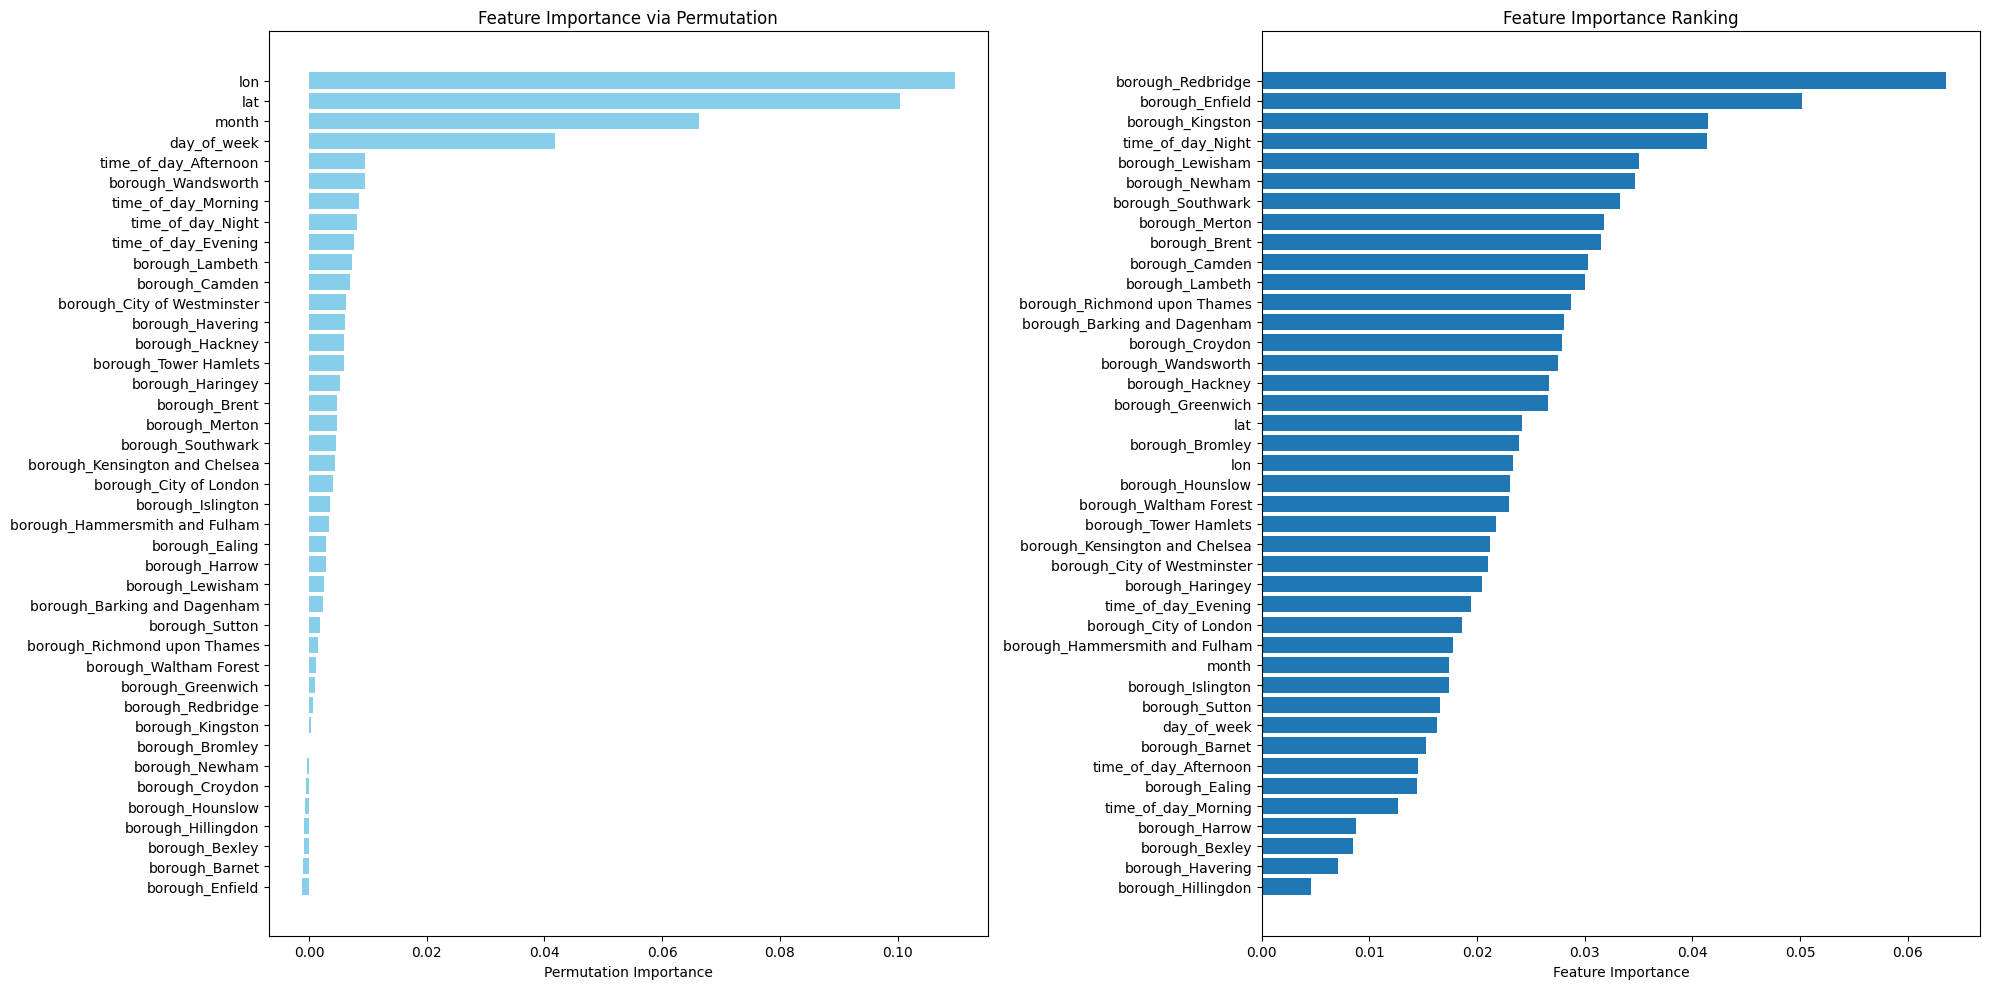

In [10]:
from sklearn.inspection import permutation_importance
feature_importance = base_xgb_model.feature_importances_

r_train = permutation_importance(base_xgb_model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Feature Importance via Permutation")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

 
y_proba      = base_xgb_model.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')


print(f'AUC score {xbm_score_test:.2f} (test)')

AUC score 0.80 (test)


Our results prove to have improved given the sample weight we can see there is not a large biass to only clasifying events as Class 0 but rather a healthy dsitribution based on amount of accidents per class.

This allows us to dive deeper into resampling techniques so that we can improve on our model.

## XGBClassifier using sample weights and ADASYN for resampling

To Focus not only on the dataset imbalance but also on model tuning we initated using Grid Search to find optimal parameters.
This combined with resampling techniques should give us a more tuned model.

Adaptive Synthetic Sampling ADASYN, an oversampling technique that generates synthetic samples for the minority class, but it does so in an adaptive way, based on how hard it is for the classifier to learn those samples.

Measure imbalances, Review Hard to Learn minorities, Generate new samples

In [11]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd

X = df.drop(columns=['severity', 'id'])
y = df['severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)

param_grid = {
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [15,20,25],
    'subsample': [0.6, 0.8],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'n_estimators': [100, 200, 300],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0.0, 0.1, 1.0],
    # 'reg_lambda': [1.0, 1.5, 2.0],
}

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,                
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_res, y_res, sample_weight=sample_weights)

print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

model_xgb_adysin = grid_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.6; total time=   5.0s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.6; total time=   5.1s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.8; total time=   5.2s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.8; total time=   5.2s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.8; total time=   5.2s
[CV] END .....learning_rate=0.3, max_depth=15, subsample=0.6; total time=   5.4s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.6; total time=   7.1s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.8; total time=   7.2s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.6; total time=   7.4s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.6; total time=   7.6s
[CV] END .....learning_rate=0.3, max_depth=20, subsample=0.8; total time=   7.1s
[CV] END .....learning_rate=0.3, max_depth=20, s

/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....learning_rate=0.4, max_depth=20, subsample=0.8; total time=   6.6s
[CV] END .....learning_rate=0.4, max_depth=20, subsample=0.8; total time=   6.6s
[CV] END .....learning_rate=0.4, max_depth=20, subsample=0.8; total time=   6.5s
[CV] END .....learning_rate=0.4, max_depth=25, subsample=0.6; total time=   7.5s
[CV] END .....learning_rate=0.4, max_depth=25, subsample=0.6; total time=   7.4s
[CV] END .....learning_rate=0.4, max_depth=25, subsample=0.6; total time=   7.1s
[CV] END .....learning_rate=0.4, max_depth=25, subsample=0.8; total time=   7.3s
[CV] END .....learning_rate=0.5, max_depth=15, subsample=0.6; total time=   4.8s
[CV] END .....learning_rate=0.5, max_depth=15, subsample=0.6; total time=   4.9s
[CV] END .....learning_rate=0.5, max_depth=15, subsample=0.8; total time=   4.8s
[CV] END .....learning_rate=0.5, max_depth=15, subsample=0.6; total time=   4.6s
[CV] END .....learning_rate=0.4, max_depth=25, subsample=0.8; total time=   7.1s
[CV] END .....learning_rate=


Classification Report:
              precision    recall  f1-score   support

      Slight      0.968     0.967     0.968      8613
     Serious      0.811     0.823     0.817      1465
       Fatal      0.947     0.750     0.837        48

    accuracy                          0.945     10126
   macro avg      0.909     0.847     0.874     10126
weighted avg      0.946     0.945     0.945     10126



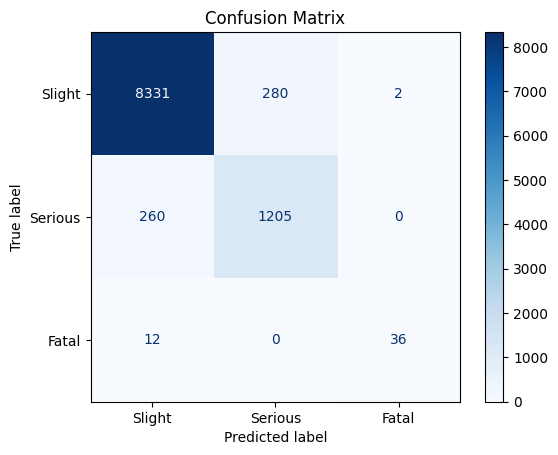

In [16]:
y_pred = model_xgb_adysin.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious', 'Fatal'], digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Computing ROC_AUC score for the model with the best parameter found.

In [17]:
from sklearn.metrics import roc_auc_score

xbm_score_cv = grid_search.best_score_  
y_proba      = model_xgb_adysin.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')
xbm_params     = grid_search.best_params_

print(f'AUC score for {xbm_params}: {xbm_score_cv:.2f} (cross-val.), {xbm_score_test:.2f} (test)')

AUC score for {'learning_rate': 0.3, 'max_depth': 25, 'subsample': 0.8}: 0.90 (cross-val.), 0.92 (test)


Printing Feature Importance and Permutation Importance from the obtained model.

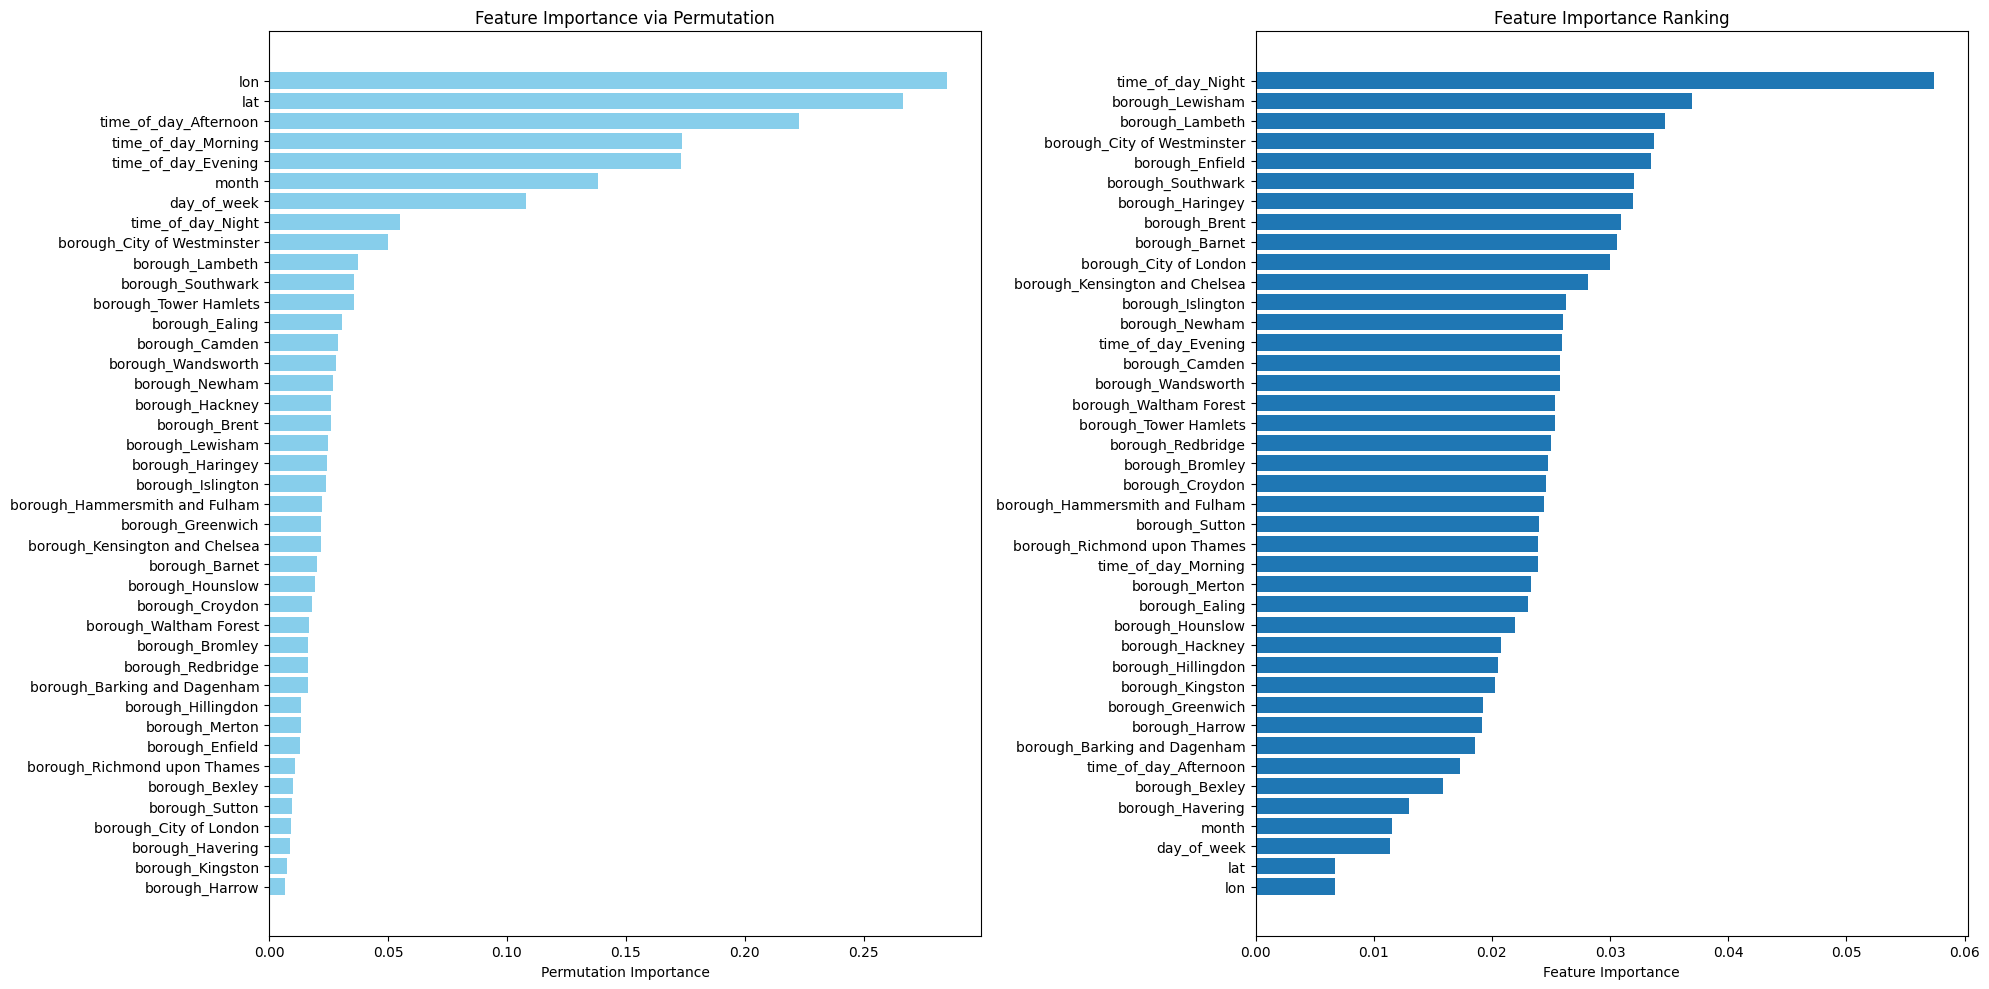

In [18]:
from sklearn.inspection import permutation_importance

feature_importance = model_xgb_adysin.feature_importances_

r_train = permutation_importance(model_xgb_adysin, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Feature Importance via Permutation")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()

Here we can see another improvement to our model, this can be attributed to both our Grid Search and utilization of ADASYN.  However we believe we can improve on our model so we look for other ways of encoding our data to limit redundancy and having too many features.

## RISK LEVEL ANALYSIS

After reviewing our current model and results we wanted to venture more into managing the data in a different way. Given that we continue to see lat and lon as the main features we consider boroughs might be redundant therefore we look for ways to encode boroughs in a different way. This is reviewed more in depth in the risk_level notebook.

We then run our analysis again using our encoded risk level dataset.

In [2]:
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_sample_weight
df_risk = pd.read_csv("Risk_level_Dataset.csv")
df_risk.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level_encoded
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,1
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,2
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,1
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,1
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,1


In [3]:
X = df_risk.drop(columns=['severity', 'id'])
y = df_risk['severity']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 9)
(10126, 9)
(40500,)
(10126,)


In [4]:
X_train_resk_level = X_train.copy()
X_test_risk_level = X_test.copy()
y_train_resk_level = y_train.copy()
y_test_resk_level = y_test.copy()  

In [5]:
# {'learning_rate': 0.4, 'max_depth': 15, 'subsample': 0.8}:
risk_level_model = XGBClassifier(random_state=42,
                                 learning_rate = 0.4,
                                 max_depth = 15,
                                 subsample = 0.8)
risk_level_model.fit(X_res, y_res, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.972     0.941     0.957      8613
           1      0.720     0.851     0.780      1465
           2      0.655     0.750     0.699        48

    accuracy                          0.927     10126
   macro avg      0.782     0.848     0.812     10126
weighted avg      0.934     0.927     0.930     10126



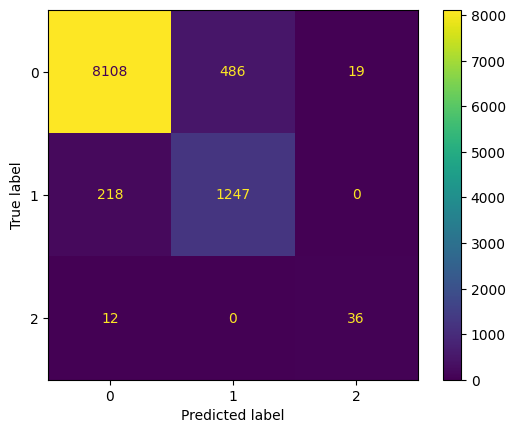

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = risk_level_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

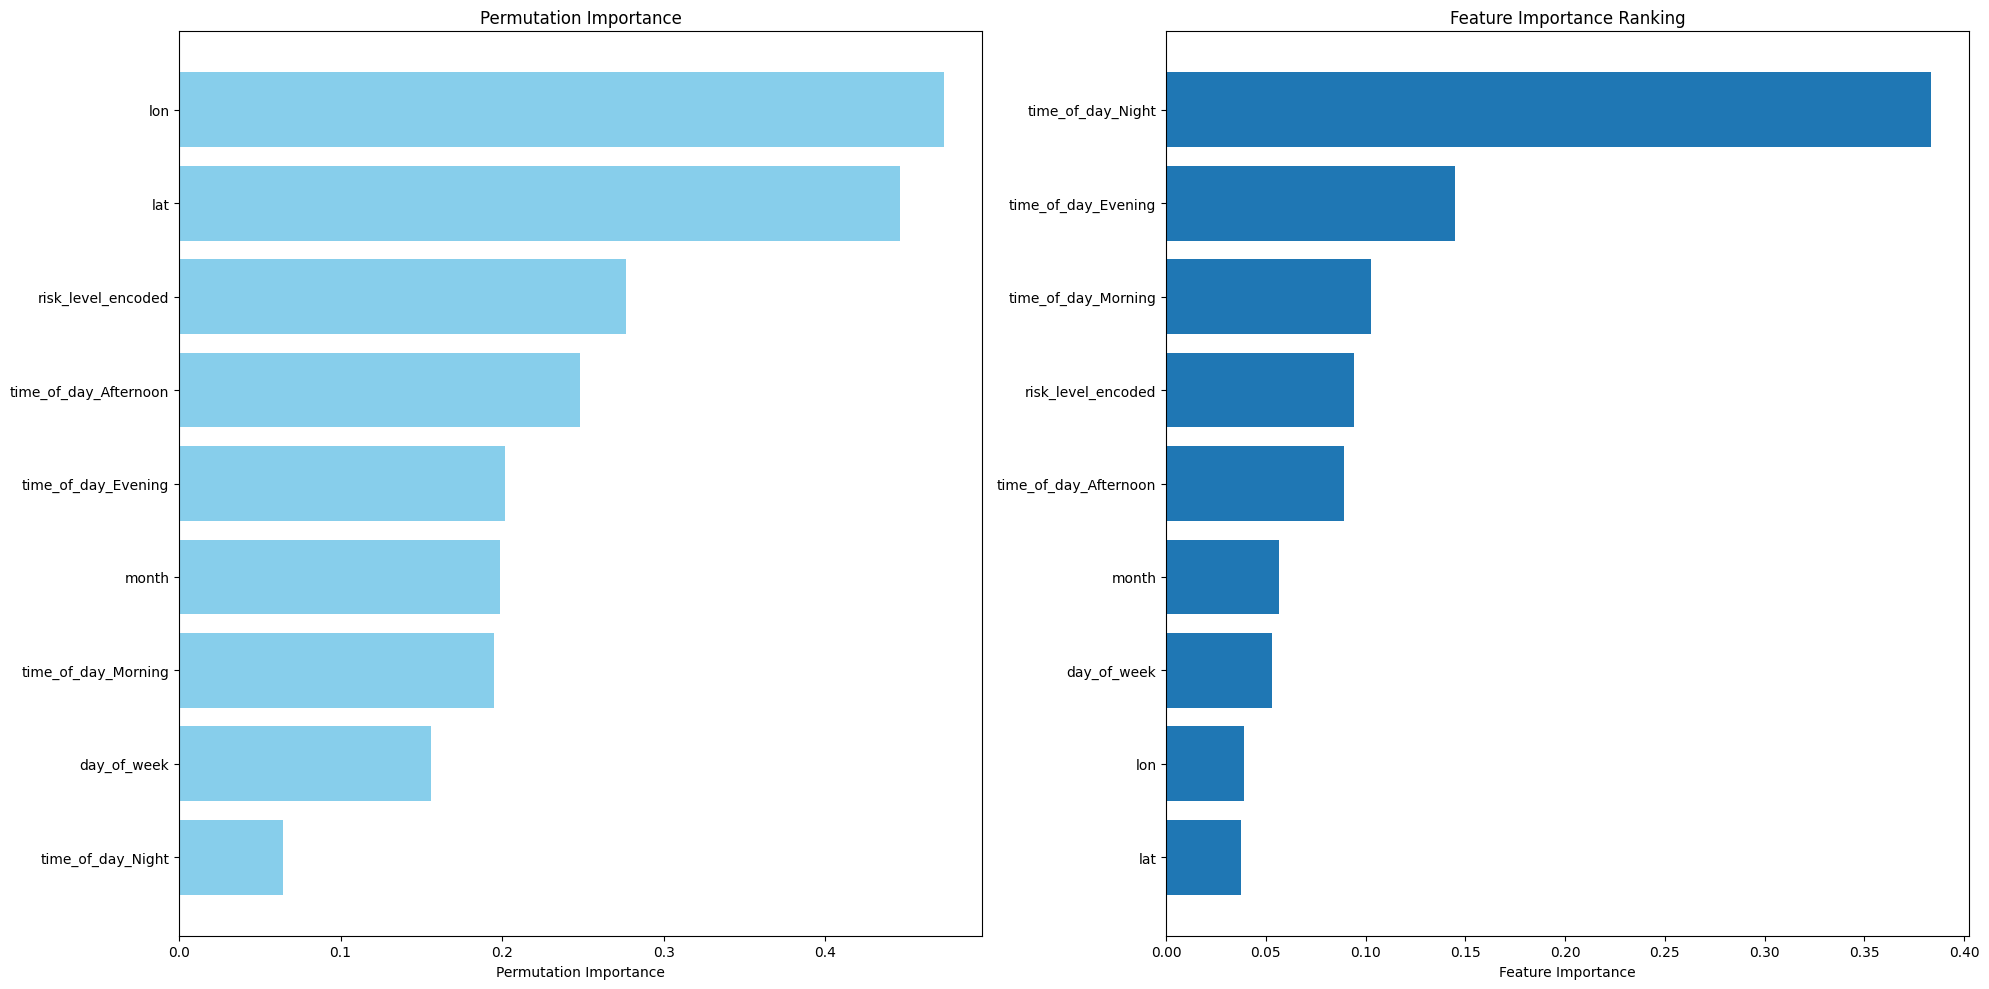

In [7]:
from sklearn.inspection import permutation_importance
feature_importance = risk_level_model.feature_importances_

r_train = permutation_importance(risk_level_model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()


## SHAP ANALYSIS

In [14]:
import shap
import numpy as np
import matplotlib.pyplot as plt

def simpler_run_shap(trained_model, test_set, feature_names=None, max_display=10):

    if feature_names is None:
        if hasattr(test_set, "columns"):
            feature_names = test_set.columns
        else:
            feature_names = [f"Feature {i}" for i in range(test_set.shape[1])]
    
    explainer = shap.TreeExplainer(trained_model)
    shap_values = explainer.shap_values(test_set)
    
    if not isinstance(shap_values, list) and shap_values.ndim == 3:
        shap_values = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
    
    if isinstance(shap_values, list):
        for i, sv in enumerate(shap_values):
            print(f"Class {i}: SHAP values shape = {sv.shape}")
    else:
        print("SHAP values shape:", shap_values.shape)
    print("Test set shape:", test_set.shape)

    for i, sv in enumerate(shap_values):
        plt.figure(figsize=(9, 5))
        shap.summary_plot(sv, test_set, feature_names=feature_names,
                          max_display=max_display, show=False)
        plt.title(f"SHAP Summary Dot Plot (Class {i})")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(9, 5))
        shap.summary_plot(sv, test_set, feature_names=feature_names, plot_type="bar",
                          max_display=max_display, show=False)
        plt.title(f"SHAP Summary Bar Plot (Class {i})")
        plt.tight_layout()
        plt.show()
    
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values_avg = np.mean([np.abs(sv) for sv in shap_values], axis=0)  
        
        plt.figure(figsize=(9, 5))
        shap.summary_plot(shap_values_avg, test_set, feature_names=feature_names, plot_type="bar",
                          max_display=max_display, show=False)
        plt.title("Global Feature Importance (Averaged Across Classes)")
        plt.tight_layout()
        plt.show()
    
    try:
        shap.initjs()
        instance = test_set.iloc[0] if hasattr(test_set, 'iloc') else test_set[0]
        force_plot = shap.force_plot(
            explainer.expected_value[0], 
            shap_values[0][0, :],
            instance,
            feature_names=feature_names
        )
    except Exception as e:
        print("Force plot could not be generated:", e)
    
    return shap_values



/Users/aaronsalazar/LocalDocs/Bologna/ai_industry/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class 0: SHAP values shape = (10126, 9)
Class 1: SHAP values shape = (10126, 9)
Class 2: SHAP values shape = (10126, 9)
Test set shape: (10126, 9)


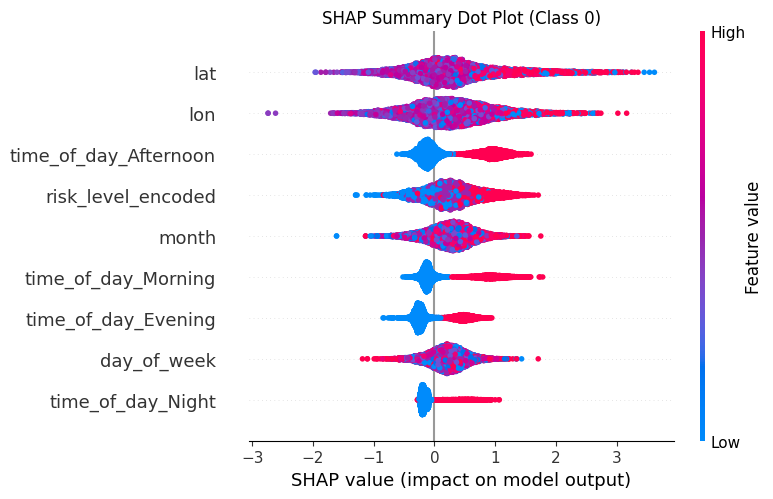

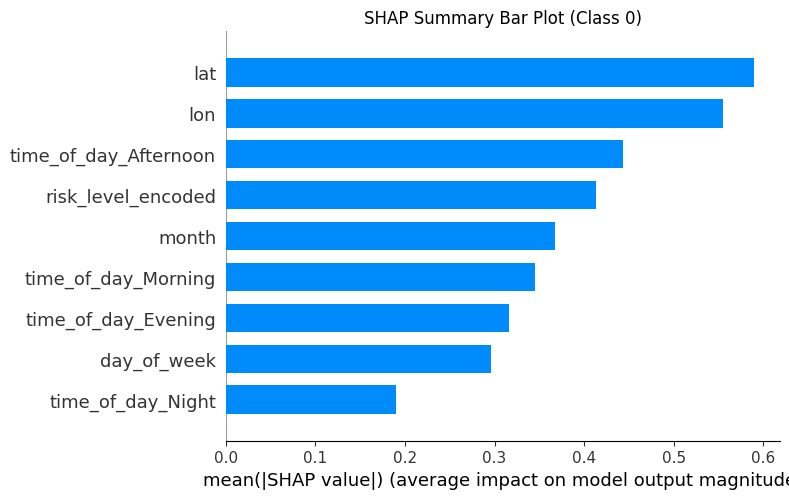

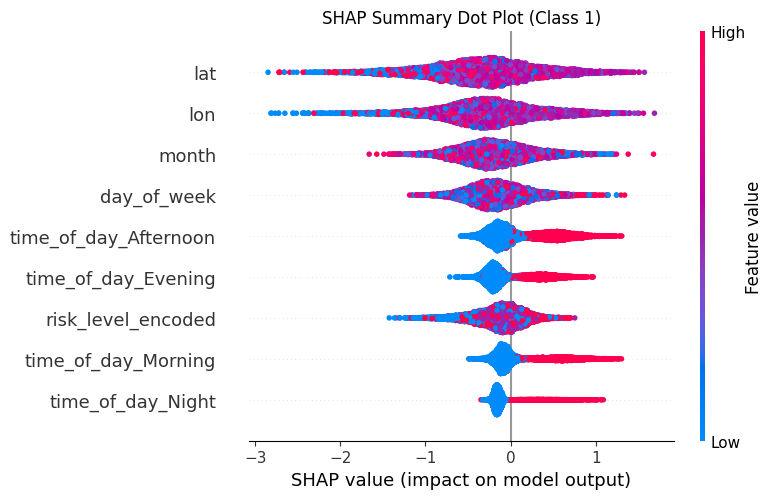

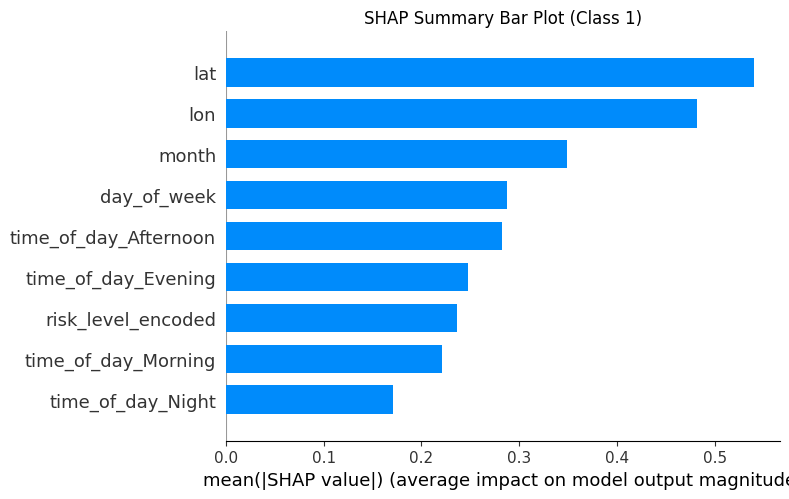

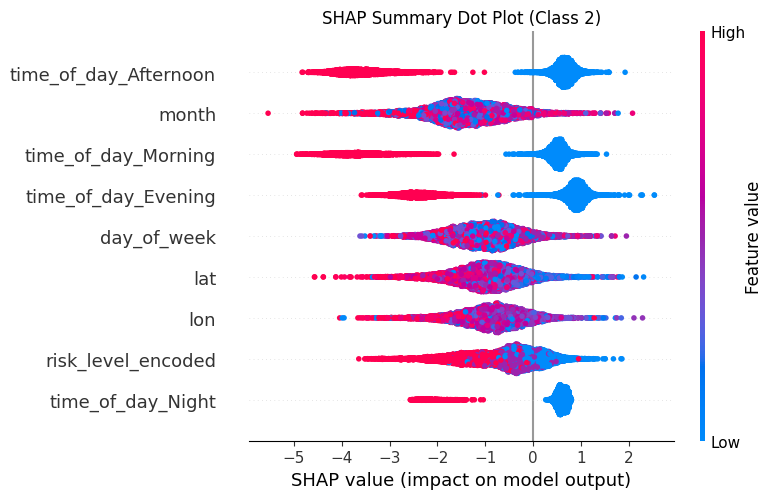

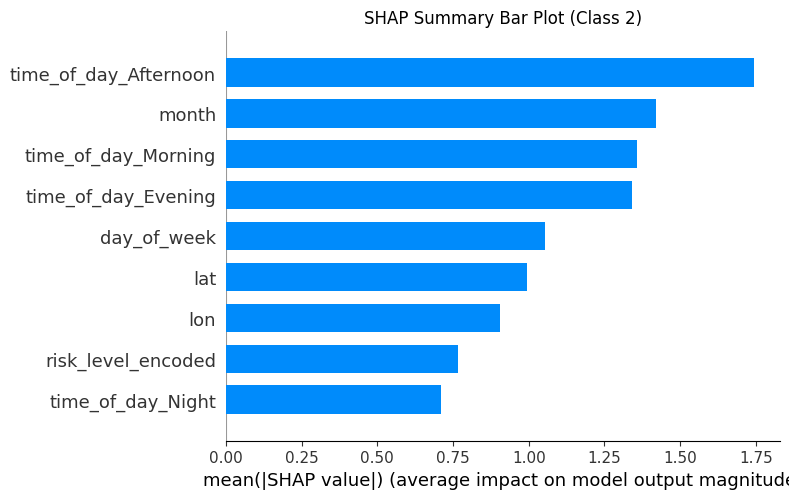

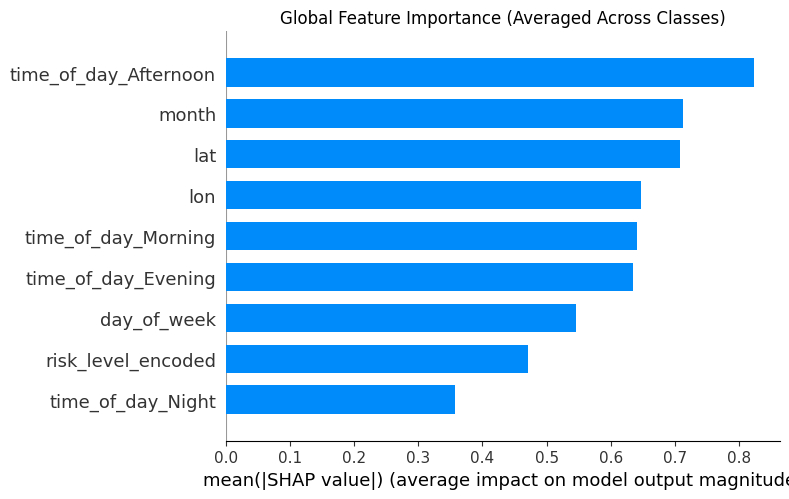

In [15]:
shap_vals = simpler_run_shap(risk_level_model, X_test_risk_level, feature_names=X_test_risk_level.columns)